In [2]:
import numpy as np
import pandas as pd
import torch
from permetrics import RegressionMetric

from experiment_runner import (
    ControlConfig,
    ProposedMethodConfig,
    run_comparison_experiments,
)
from svd_based_optimizer import SvdOptimizer
from ols_optimizer import OlsOptimizer
import matplotlib.pyplot as plt
from dimension_estimation import estimate_dimension, OptimalDimensionSelectionMethod, CaoEstimator
from lag_estimation import estimate_tau, OptimalLagSelectionMethod, AmiEstimator
from cv_embedding_estimation import CrossValidationEmbeddingEstimator, estimate_embedding_cv


## Loading the dataset

In [3]:
# dataset = pd.read_csv(r".\data\SeriesReport-Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv")
dataset = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/lynx.csv',
                   index_col=0)
dataset.set_index('time', inplace=True)
dataset.head()

,value
time,
1821,269
1822,321
1823,585
1824,871
1825,1475


In [4]:
dataset.describe()

,value
count,114.000000
mean,1538.017544
std,1585.843914
min,39.000000
25%,348.250000
50%,771.000000
75%,2566.750000
max,6991.000000


In [5]:
# time_series = dataset['Value'].values
time_series = dataset['value'].values
time_series = time_series[np.nonzero(~np.isnan(time_series))]

In [6]:
# time_series_mu = np.mean(time_series)
# time_series_std = np.std(time_series)

# time_series = np.diff(time_series, prepend=time_series[0])
# time_series = (time_series - time_series_mu) / time_series_std
time_series = np.log10(time_series)

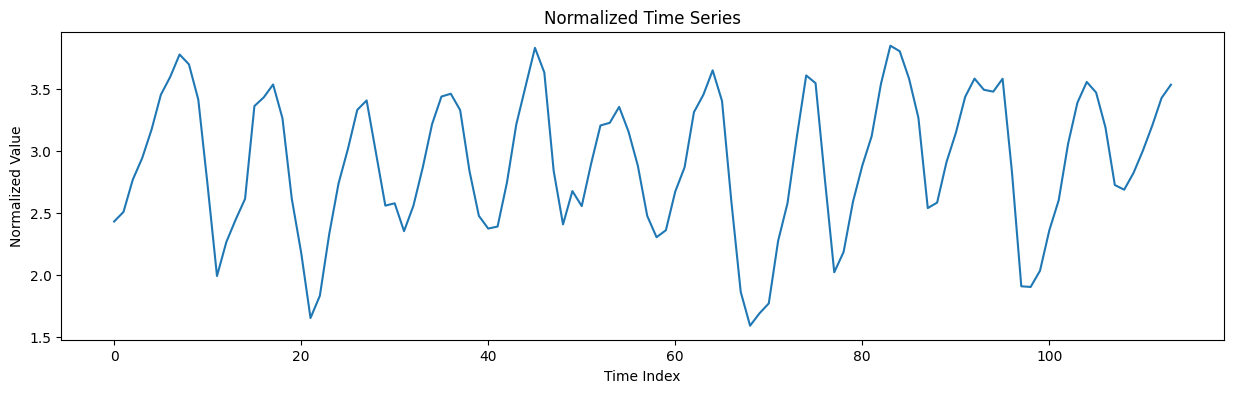

In [7]:
plt.figure(figsize=(15, 4))
plt.plot(time_series)
plt.title('Normalized Time Series')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.show()

## Estimating the embedding parameters

In [8]:
ami_tau = estimate_tau(
    time_series,
    estimator=AmiEstimator(
        max_lag=20, optimum_selection_method=OptimalLagSelectionMethod.FIRST_LOC_MIN
    ),
)
print(f"Estimated tau: {ami_tau}")

Estimated tau: 2


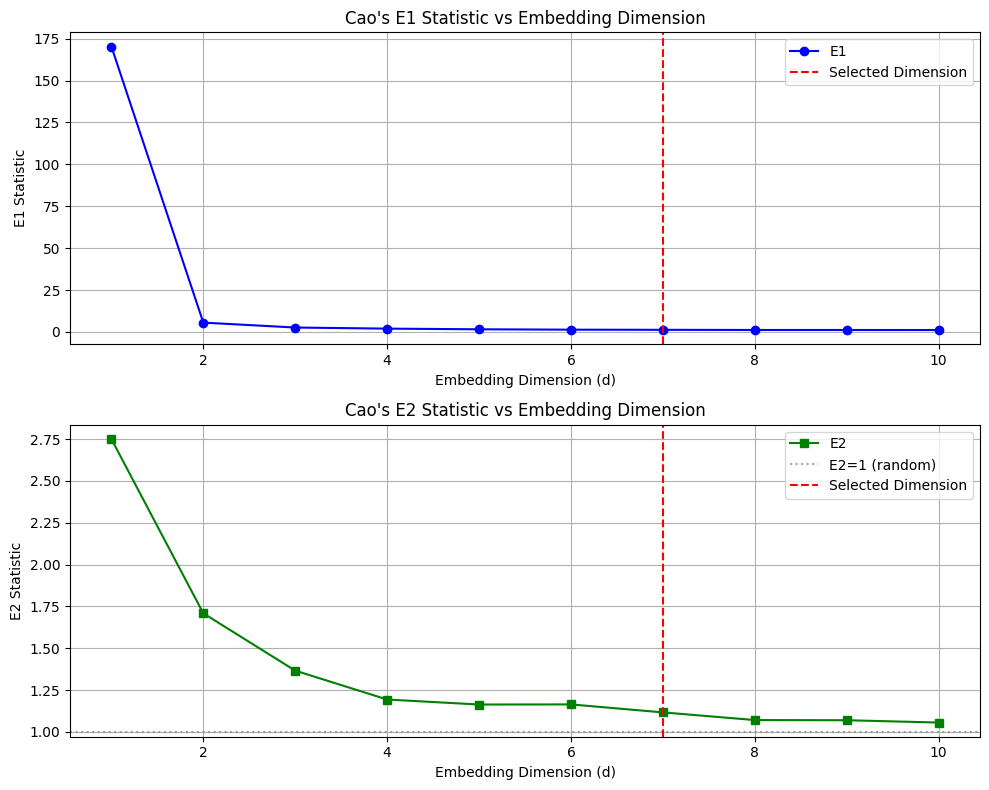

Estimated dimension: 7


In [9]:
cao_dim = estimate_dimension(
    time_series,
    estimator=CaoEstimator(
        delay=ami_tau,
        max_dim=10,
        optimum_selection_method=OptimalDimensionSelectionMethod.E1_E2_COMBINED,
        plot=True,
    ),
)
print(f"Estimated dimension: {cao_dim}")

## Testing Cross-Validation Embedding Estimation

Let's compare the traditional AMI + Cao's method with the new modified multifold cross-validation criterion for embedding parameter estimation.

In [10]:
# Compare traditional AMI + Cao estimation with CV-based estimation
print("=== Traditional Methods (AMI + Cao) ===")
print(f"AMI estimated tau: {ami_tau}")
print(f"Cao estimated dimension: {cao_dim}")

# Use CV-based estimation with a smaller parameter space for faster computation
print("\n=== Cross-Validation Based Estimation ===")
cv_estimator = CrossValidationEmbeddingEstimator(
    tau_range=(1, 5),      # Smaller range for demonstration
    dim_range=(2, 6),      # Smaller range for demonstration  
    n_splits=3,            # Fewer splits for faster computation
    scoring_metric="mse",  # Mean squared error
    verbose=False
)

tau_cv, dim_cv = cv_estimator.estimate(time_series)
print(f"CV estimated tau: {tau_cv}")
print(f"CV estimated dimension: {dim_cv}")

=== Traditional Methods (AMI + Cao) ===
AMI estimated tau: 2
Cao estimated dimension: 7

=== Cross-Validation Based Estimation ===
CV estimated tau: 1
CV estimated dimension: 2


In [11]:
# You can also try different scoring metrics
print("\n=== CV with different scoring metrics ===")

metrics = ["mse", "mae", "r2"]
cv_results = {}

for metric in metrics:
    estimator = CrossValidationEmbeddingEstimator(
        tau_range=(1, 4),
        dim_range=(2, 5),
        n_splits=3,
        scoring_metric=metric,
        verbose=False  # Set to True to see progress
    )
    tau_est, dim_est = estimator.estimate(time_series)
    cv_results[metric] = (tau_est, dim_est)
    print(f"{metric.upper()} metric: tau={tau_est}, dim={dim_est}")

print(f"\nComparison:")
print(f"Traditional (AMI+Cao): tau={ami_tau}, dim={cao_dim}")
for metric, (tau_est, dim_est) in cv_results.items():
    print(f"CV ({metric}): tau={tau_est}, dim={dim_est}")


=== CV with different scoring metrics ===
MSE metric: tau=1, dim=2
MAE metric: tau=1, dim=2
R2 metric: tau=1, dim=2

Comparison:
Traditional (AMI+Cao): tau=2, dim=7
CV (mse): tau=1, dim=2
CV (mae): tau=1, dim=2
CV (r2): tau=1, dim=2


## Configuring the models

In [12]:
tau, dim = tau_cv, dim_cv

In [50]:
proposed_configs = [
    *[
        ProposedMethodConfig(
            approach=approach,
            optimizer=SvdOptimizer(epsilon=eps, alpha=alpha),
            # m=m,
            post_tune=post_tune,
            n=dim,
            embedding_tau=tau,
            tuning_val_split=0.3,
            ridge=ridge
        )
        # for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
        for alpha in [0, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1, 5e-1, 1, 1.5, 2, 2.5, 3.5, 5, 8, 10, 20]
        for post_tune in [True, False]
        for eps in [0.0001, 0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
        for ridge in [0.0, 1e-4, 1e-3, 1e-2]
        for approach in ["pretraining", "no-pretraining"]
    ],
    *[
        ProposedMethodConfig(
            approach=approach,
            optimizer=OlsOptimizer(rho=rho),
            m=max_m,
            n=dim,
            embedding_tau=tau,
            post_tune=post_tune,
        )
        for max_m in [50]
        for rho in [0.01, 0.05, 0.1]
        for post_tune in [True, False]
        for approach in ["pretraining", "no-pretraining"]
    ],
]

control_configs = [
    ControlConfig(
        m=m,
        n=dim,
        embedding_tau=tau,
        lr=lr,
        sigma_global=sigma_global,
        ridge=ridge,
        val_split=0.2,
    )
    for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
    for lr in [1e-3, 1e-2, 5e-2, 1e-1]
    for ridge in [0.0, 1e-4, 1e-3, 1e-2]
    for sigma_global in [False, True]
]

In [51]:
proposed_results, control_results = run_comparison_experiments(
        time_series,
        proposed_configs,
        control_configs,
        train_ratio=0.88, # 0.88 matches the article which introduces the EM-VP algorithm
        device="cuda" if torch.cuda.is_available() else "cpu",
        run_parallel=False,
        show_progress=True,
    )

if not isinstance(proposed_results, list):
    proposed_results = [proposed_results]
if not isinstance(control_results, list):
    control_results = [control_results]

Running Experiments: 100%|██████████| 3084/3084 [03:09<00:00, 16.25experiment/s] 


## Evaluating the results

In [52]:
results_df = pd.DataFrame(
    {
        "Type": [],
        "Name": [],
        "Test R": [],
        "Test R^2": [],
        "Test MSE": [],
        "Test RMSE": [],
        "Test NRMSE": [],
        "Test MAPE": [],
        "Test SMAPE": [],
        "Test MAAPE": [],
    }
)

for i, res in enumerate(proposed_results):
    
    cfg = proposed_configs[i]
    
    test_metrics = RegressionMetric(
        y_pred=res.test_predictions,
        y_true=res.test_targets,
    )

    new_row = pd.DataFrame(
        {
            "Type": ["Proposed"],
            "Name": [
                f"{res.metadata['optimizer_type']}-w.{cfg.approach}(m={res.metadata['total_centers']}, alpha={res.metadata['optimizer_params']['_alpha']}, eps={cfg.optimizer._epsilon} tuned={res.metadata['post_tuned']})" if res.metadata["optimizer_type"] == "SvdOptimizer" else
                f"{res.metadata['optimizer_type']}-w.{cfg.approach}(|C|={res.metadata['selected_centers']}, rho={res.metadata['optimizer_params']['_rho']} tuned={res.metadata['post_tuned']})"
            ],
            "Test R": [test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [test_metrics.R2()],
            "Test RMSE": [test_metrics.root_mean_squared_error()],
            "Test NRMSE": [test_metrics.normalized_root_mean_square_error()],
            "Test MAPE": [test_metrics.mean_absolute_percentage_error()],
            "Test SMAPE": [test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [test_metrics.mean_arctangent_absolute_percentage_error()],
            "Test MSE": [test_metrics.mean_squared_error()],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

for i, res in enumerate(control_results):
    
    cfg = control_configs[i]
    
    control_test_metrics = RegressionMetric(
        y_pred=res.test_predictions,
        y_true=res.test_targets,
    )

    new_row = pd.DataFrame(
        {
            "Type": ["Control"],
            "Name": [f"Control (m={res.metadata['m_ctrl']}, lr={cfg.lr}, ridge={cfg.ridge})"],
            "Test R": [control_test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [control_test_metrics.R2()],
            "Test NRMSE": [control_test_metrics.normalized_root_mean_square_error()],
            "Test SMAPE": [control_test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [control_test_metrics.mean_arctangent_absolute_percentage_error()],
            "Test MAPE": [control_test_metrics.mean_absolute_percentage_error()],
            "Test RMSE": [control_test_metrics.root_mean_squared_error()],
            "Test MSE": [control_test_metrics.mean_squared_error()],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

In [53]:
# PROPOSED_MODEL_SELECTION_CRITERION = "Test R^2"
# PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE = True

PROPOSED_MODEL_SELECTION_CRITERION = "Test MSE"
PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE = False

In [54]:
results_df.groupby("Type")[results_df.columns].apply(lambda x: x.sort_values(by=PROPOSED_MODEL_SELECTION_CRITERION, ascending=not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE).drop(columns=["Type"]).head(5))

Name    Test R  \
Type                                                                         
Control  3054             Control (m=20, lr=0.001, ridge=0.0001)  0.958135   
         3052                Control (m=20, lr=0.001, ridge=0.0)  0.958135   
         3058               Control (m=20, lr=0.001, ridge=0.01)  0.958135   
         3056              Control (m=20, lr=0.001, ridge=0.001)  0.958135   
         3020                Control (m=15, lr=0.001, ridge=0.0)  0.956442   
Proposed 806   SvdOptimizer-w.pretraining(m=100, alpha=0.01, ...  0.978072   
         814   SvdOptimizer-w.pretraining(m=100, alpha=0.01, ...  0.978072   
         804   SvdOptimizer-w.pretraining(m=100, alpha=0.01, ...  0.978065   
         810   SvdOptimizer-w.pretraining(m=100, alpha=0.01, ...  0.978065   
         812   SvdOptimizer-w.pretraining(m=100, alpha=0.01, ...  0.978065   

               Test R^2  Test MSE  Test RMSE  Test NRMSE  Test MAPE  \
Type                                                                  
Control  3054  0.916494  0.011450   0.107004    0.290324   0.027950   
         3052  0.916494  0.011450   0.107004    0.290324   0.027950   
         3058  0.916494  0.011450   0.107004    0.290324   0.027950   
         3056  0.916494  0.011450   0.107004    0.290324   0.027950   
         3020  0.912597  0.011984   0.109473    0.295929   0.027808   
Proposed 806   0.950982  0.006721   0.081982    0.216684   0.023502   
         814   0.950979  0.006722   0.081985    0.216689   0.023503   
         804   0.950971  0.006723   0.081991    0.216726   0.023510   
         810   0.950971  0.006723   0.081992    0.216728   0.023510   
         812   0.950971  0.006723   0.081992    0.216726   0.023510   

               Test SMAPE  Test MAAPE  
Type                                   
Control  3054    0.014138    0.027915  
         3052    0.014138    0.027915  
         3058    0.014138    0.027915  
         3056    0.014138    0.027915  
         3020    0.014083    0.027770  
Proposed 806     0.011734    0.023492  
         814     0.011734    0.023493  
         804     0.011737    0.023499  
         810     0.011738    0.023500  
         812     0.011737    0.023499

In [55]:
print(f"Best proposed model is: {results_df.sort_values(by=["Type", PROPOSED_MODEL_SELECTION_CRITERION], ascending=[False, not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE]).head(1)["Name"].values[0]}")

Best proposed model is: SvdOptimizer-w.pretraining(m=100, alpha=0.01, eps=0.0001 tuned=True)


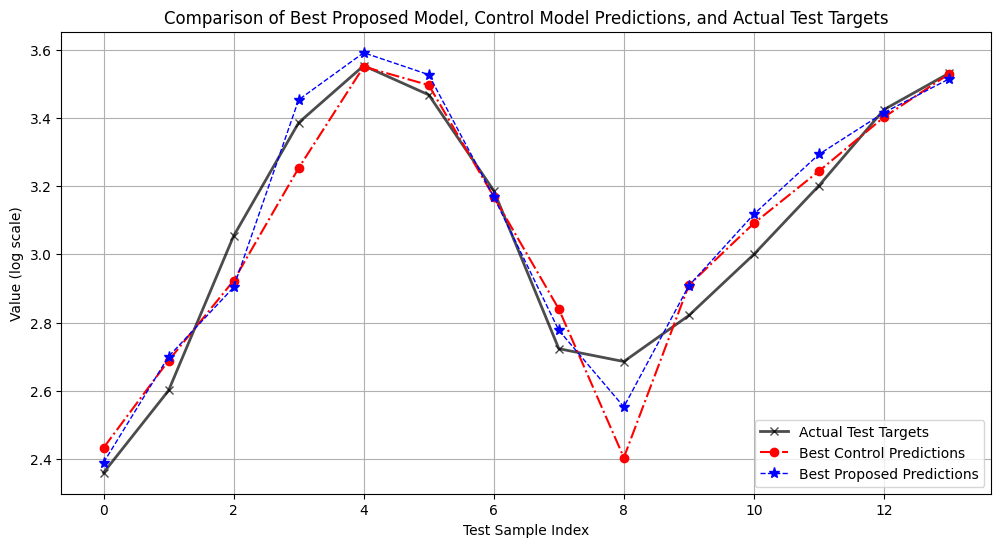

In [56]:
# Find the index of the best proposed model based on lowest Test NRMSE
best_proposed_idx = results_df[results_df["Type"] == "Proposed"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmax() if PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Proposed"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmin()
best_proposed_res = proposed_results[best_proposed_idx]

best_control_idx = results_df[results_df["Type"] == "Control"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmax() if PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Control"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmin()
best_control_res = control_results[best_control_idx - len(proposed_results)]

# Get test targets (actual values for test set)
test_targets = best_proposed_res.test_targets  # Assuming all have the same test_targets

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_targets, label="Actual Test Targets", color="black", linewidth=2, marker="x", alpha=.7)
plt.plot(
    best_control_res.test_predictions,
    label=f"Best Control Predictions",
    color="red",
    linestyle="-.",
    marker='o',
)
plt.plot(
    best_proposed_res.test_predictions,
    label=f'Best Proposed Predictions',
    color="blue",
    linestyle="--",
    linewidth=1,
    marker='*',
    markersize=8,
)
plt.xlabel("Test Sample Index")
plt.ylabel("Value (log scale)")
plt.title(
    "Comparison of Best Proposed Model, Control Model Predictions, and Actual Test Targets"
)
plt.legend()
plt.grid(True)
plt.show()

### Control models

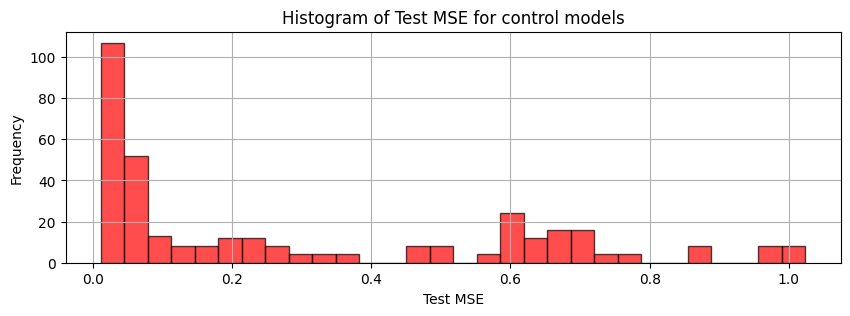

In [57]:
control_models = results_df[results_df["Type"] == "Control"]
plt.figure(figsize=(10, 3))
plt.hist(control_models[PROPOSED_MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title(f'Histogram of {PROPOSED_MODEL_SELECTION_CRITERION} for control models')
plt.xlabel(PROPOSED_MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Breakdown of methods

#### Best OLS model without tuning

In [58]:
# Filter for models with "OLS" in their name (case-insensitive) and "tuned=False"
not_tuned_ols_models = results_df[
    results_df["Name"].str.contains("OLS", case=False, na=False)
    & results_df["Name"].str.contains("tuned=False", case=False, na=False)
]

if not_tuned_ols_models.empty:
    best_not_tuned_ols_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_not_tuned_ols_model = not_tuned_ols_models.loc[
        (
            not_tuned_ols_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmin()
            if not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else not_tuned_ols_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

print(best_not_tuned_ols_model["Name"])
print("=" * 20)
print(best_not_tuned_ols_model.drop(labels=["Type", "Name"]))

OlsOptimizer-w.pretraining(|C|=50, rho=0.05 tuned=False)
Test R           0.652844
Test R^2     -330269.7236
Test MSE      45285.08688
Test RMSE       212.80293
Test NRMSE       1.196006
Test MAPE       66.617751
Test SMAPE        0.97228
Test MAAPE       1.552605
Name: 2726, dtype: object


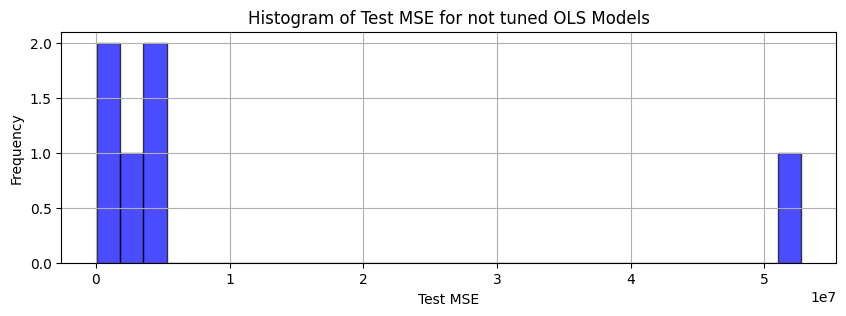

In [59]:
plt.figure(figsize=(10, 3))
plt.hist(not_tuned_ols_models[PROPOSED_MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Histogram of {PROPOSED_MODEL_SELECTION_CRITERION} for not tuned OLS Models')
plt.xlabel(PROPOSED_MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Best OLS-based model with tuning

In [60]:
# Filter for models with "OLS" in their name (case-insensitive) and "tuned=False"
tuned_ols_models = results_df[results_df["Name"].str.contains("OLS", case=False, na=False) & 
                        results_df["Name"].str.contains("tuned=True", case=False, na=False)]

if tuned_ols_models.empty:
    best_tuned_ols_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_tuned_ols_model = tuned_ols_models.loc[
        (
            tuned_ols_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmin()
            if not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else tuned_ols_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

print(best_tuned_ols_model["Name"])
print("="*20)
print(best_tuned_ols_model.drop(labels=["Type", "Name"]))

OlsOptimizer-w.no-pretraining(|C|=100, rho=0.05 tuned=True)
Test R           -0.33373
Test R^2     -2141.931877
Test MSE       293.828212
Test RMSE       17.141418
Test NRMSE       1.155661
Test MAPE        4.538142
Test SMAPE       0.663868
Test MAAPE       1.127193
Name: 2725, dtype: object


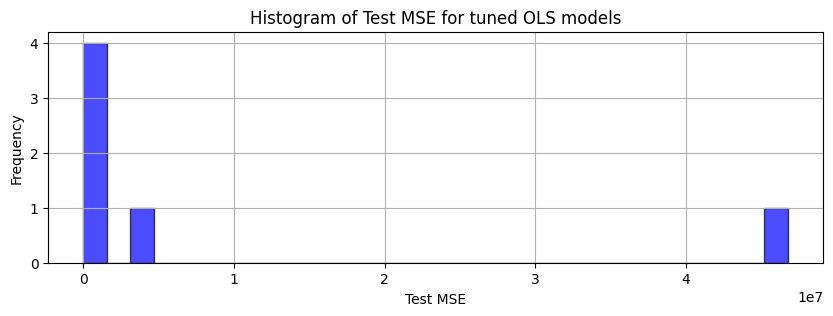

In [61]:
plt.figure(figsize=(10, 3))
plt.hist(tuned_ols_models[PROPOSED_MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Histogram of {PROPOSED_MODEL_SELECTION_CRITERION} for tuned OLS models')
plt.xlabel(PROPOSED_MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Best SVD-based model without tuning

In [62]:
# Filter for models with "SVD" in their name (case-insensitive) and "tuned=True"
not_tuned_svd_models = results_df[results_df["Name"].str.contains("SVD", case=False, na=False)]
not_tuned_svd_models = not_tuned_svd_models[not_tuned_svd_models["Name"].str.contains("tuned=False", case=False, na=False)]

if not_tuned_svd_models.empty:
    best_not_tuned_svd_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_not_tuned_svd_model = not_tuned_svd_models.loc[
        (
            not_tuned_svd_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmin()
            if not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else not_tuned_svd_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

print(best_not_tuned_svd_model["Name"])
print("="*20)
print(best_not_tuned_svd_model.drop(labels=["Type", "Name"]))

SvdOptimizer-w.no-pretraining(m=100, alpha=0.1, eps=0.001 tuned=False)
Test R        0.978242
Test R^2      0.949323
Test MSE      0.006949
Test RMSE     0.083358
Test NRMSE    0.225657
Test MAPE     0.020401
Test SMAPE    0.010352
Test MAAPE    0.020387
Name: 1055, dtype: object


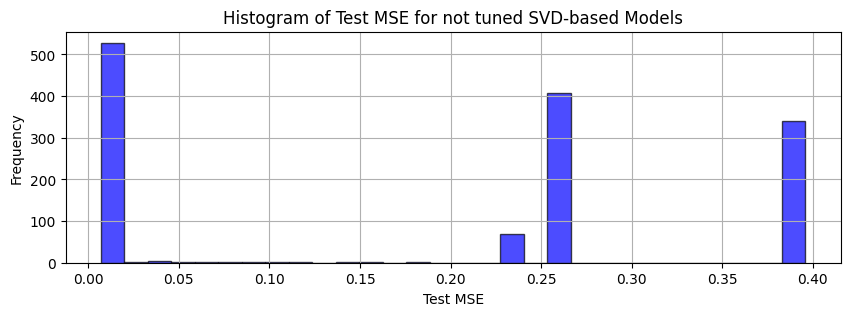

In [63]:
plt.figure(figsize=(10, 3))
plt.hist(not_tuned_svd_models[PROPOSED_MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Histogram of {PROPOSED_MODEL_SELECTION_CRITERION} for not tuned SVD-based Models')
plt.xlabel(PROPOSED_MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Best SVD-based model with tuning

In [64]:
# Filter for models with "SVD" in their name (case-insensitive) and "tuned=True"
tuned_svd_models = results_df[results_df["Name"].str.contains("SVD", case=False, na=False)]
tuned_svd_models = tuned_svd_models[
    tuned_svd_models["Name"].str.contains("tuned=True", case=False, na=False)
]

if tuned_svd_models.empty:
    best_tuned_svd_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_tuned_svd_model = tuned_svd_models.loc[
        (
            tuned_svd_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmin()
            if not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else tuned_svd_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

print(best_tuned_svd_model["Name"])
print("=" * 20)
print(best_tuned_svd_model.drop(labels=["Type", "Name"]))

SvdOptimizer-w.pretraining(m=100, alpha=0.01, eps=0.0001 tuned=True)
Test R        0.978072
Test R^2      0.950982
Test MSE      0.006721
Test RMSE     0.081982
Test NRMSE    0.216684
Test MAPE     0.023502
Test SMAPE    0.011734
Test MAAPE    0.023492
Name: 806, dtype: object


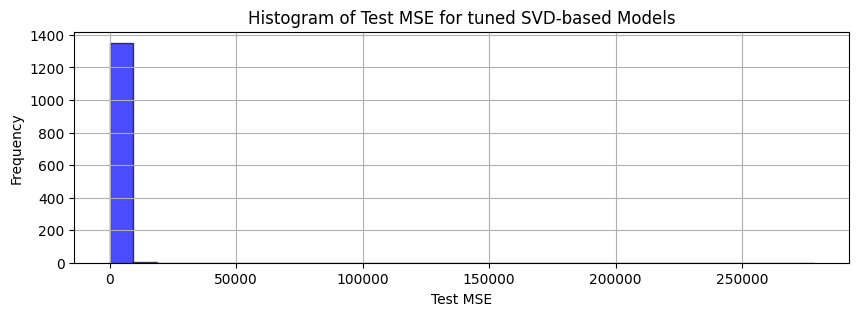

In [65]:
plt.figure(figsize=(10, 3))
plt.hist(tuned_svd_models[PROPOSED_MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Histogram of {PROPOSED_MODEL_SELECTION_CRITERION} for tuned SVD-based Models')
plt.xlabel(PROPOSED_MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()